# October 10-18, 2022: Near miss analysis

In [1]:
import bct
import csv
import os
import pickle
import random
import sys
from copy import deepcopy
from itertools import combinations
from os.path import join as pjoin

import networkx as nx
import numpy as np
import pandas as pd
import scipy as sp
from brainiak.isc import compute_correlation, squareform_isfc
from scipy import signal
from tqdm.notebook import tqdm

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/oct22"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils_v1 as dataset_utils
import helpers.isc_utils as isc_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.SEED = 74
np.random.seed(args.SEED)

args.APPR = 1
args.RETR = -1
args.NAMES = ['NEAR_MISS', 'APPR', 'RETR']
args.TRIAL_LEN = 15
args.near_miss_thresh = [0.77, 0.88]
args.near_miss_width = 7.5
args.min_window_length = 12
# args.window_shift = 3
args.SEGMENT_TRS = np.arange(-7, 8)
args.TR = 1.25

In [3]:
args.proj_dir = proj_dir
# stimulus file
# copied Joyneel's pkl file 
with open(
    f"/home/govindas/network_dynamics/data/emoprox2/data/emoprox_motion_parameters.pkl", 
    'rb'
) as f:
    motion_df = pickle.load(f)
# motion_df

args.roi_set_name = 'mashid'
args.main_data_dir = (
    f"{proj_dir}/data/emoprox2/data/rois_{args.roi_set_name}"
)

# exploratory data
args.subjects = np.unique(motion_df.pid.values)
random.Random(args.SEED).shuffle(args.subjects)
args.explor_subjects = args.subjects[ : round(0.25 * len(args.subjects))]

# ROIs
args = dataset_utils.get_mashid_rois(args)
args = dataset_utils.get_mashid_plot_tick_labels(args)

[13 12 12  8]
[13 25 37]
[ 7 19 31 41]
['Salience' 'Executive' 'Task negative' 'Subcortical']


## dataset

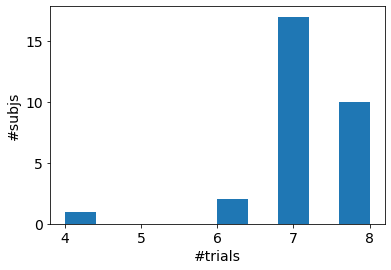

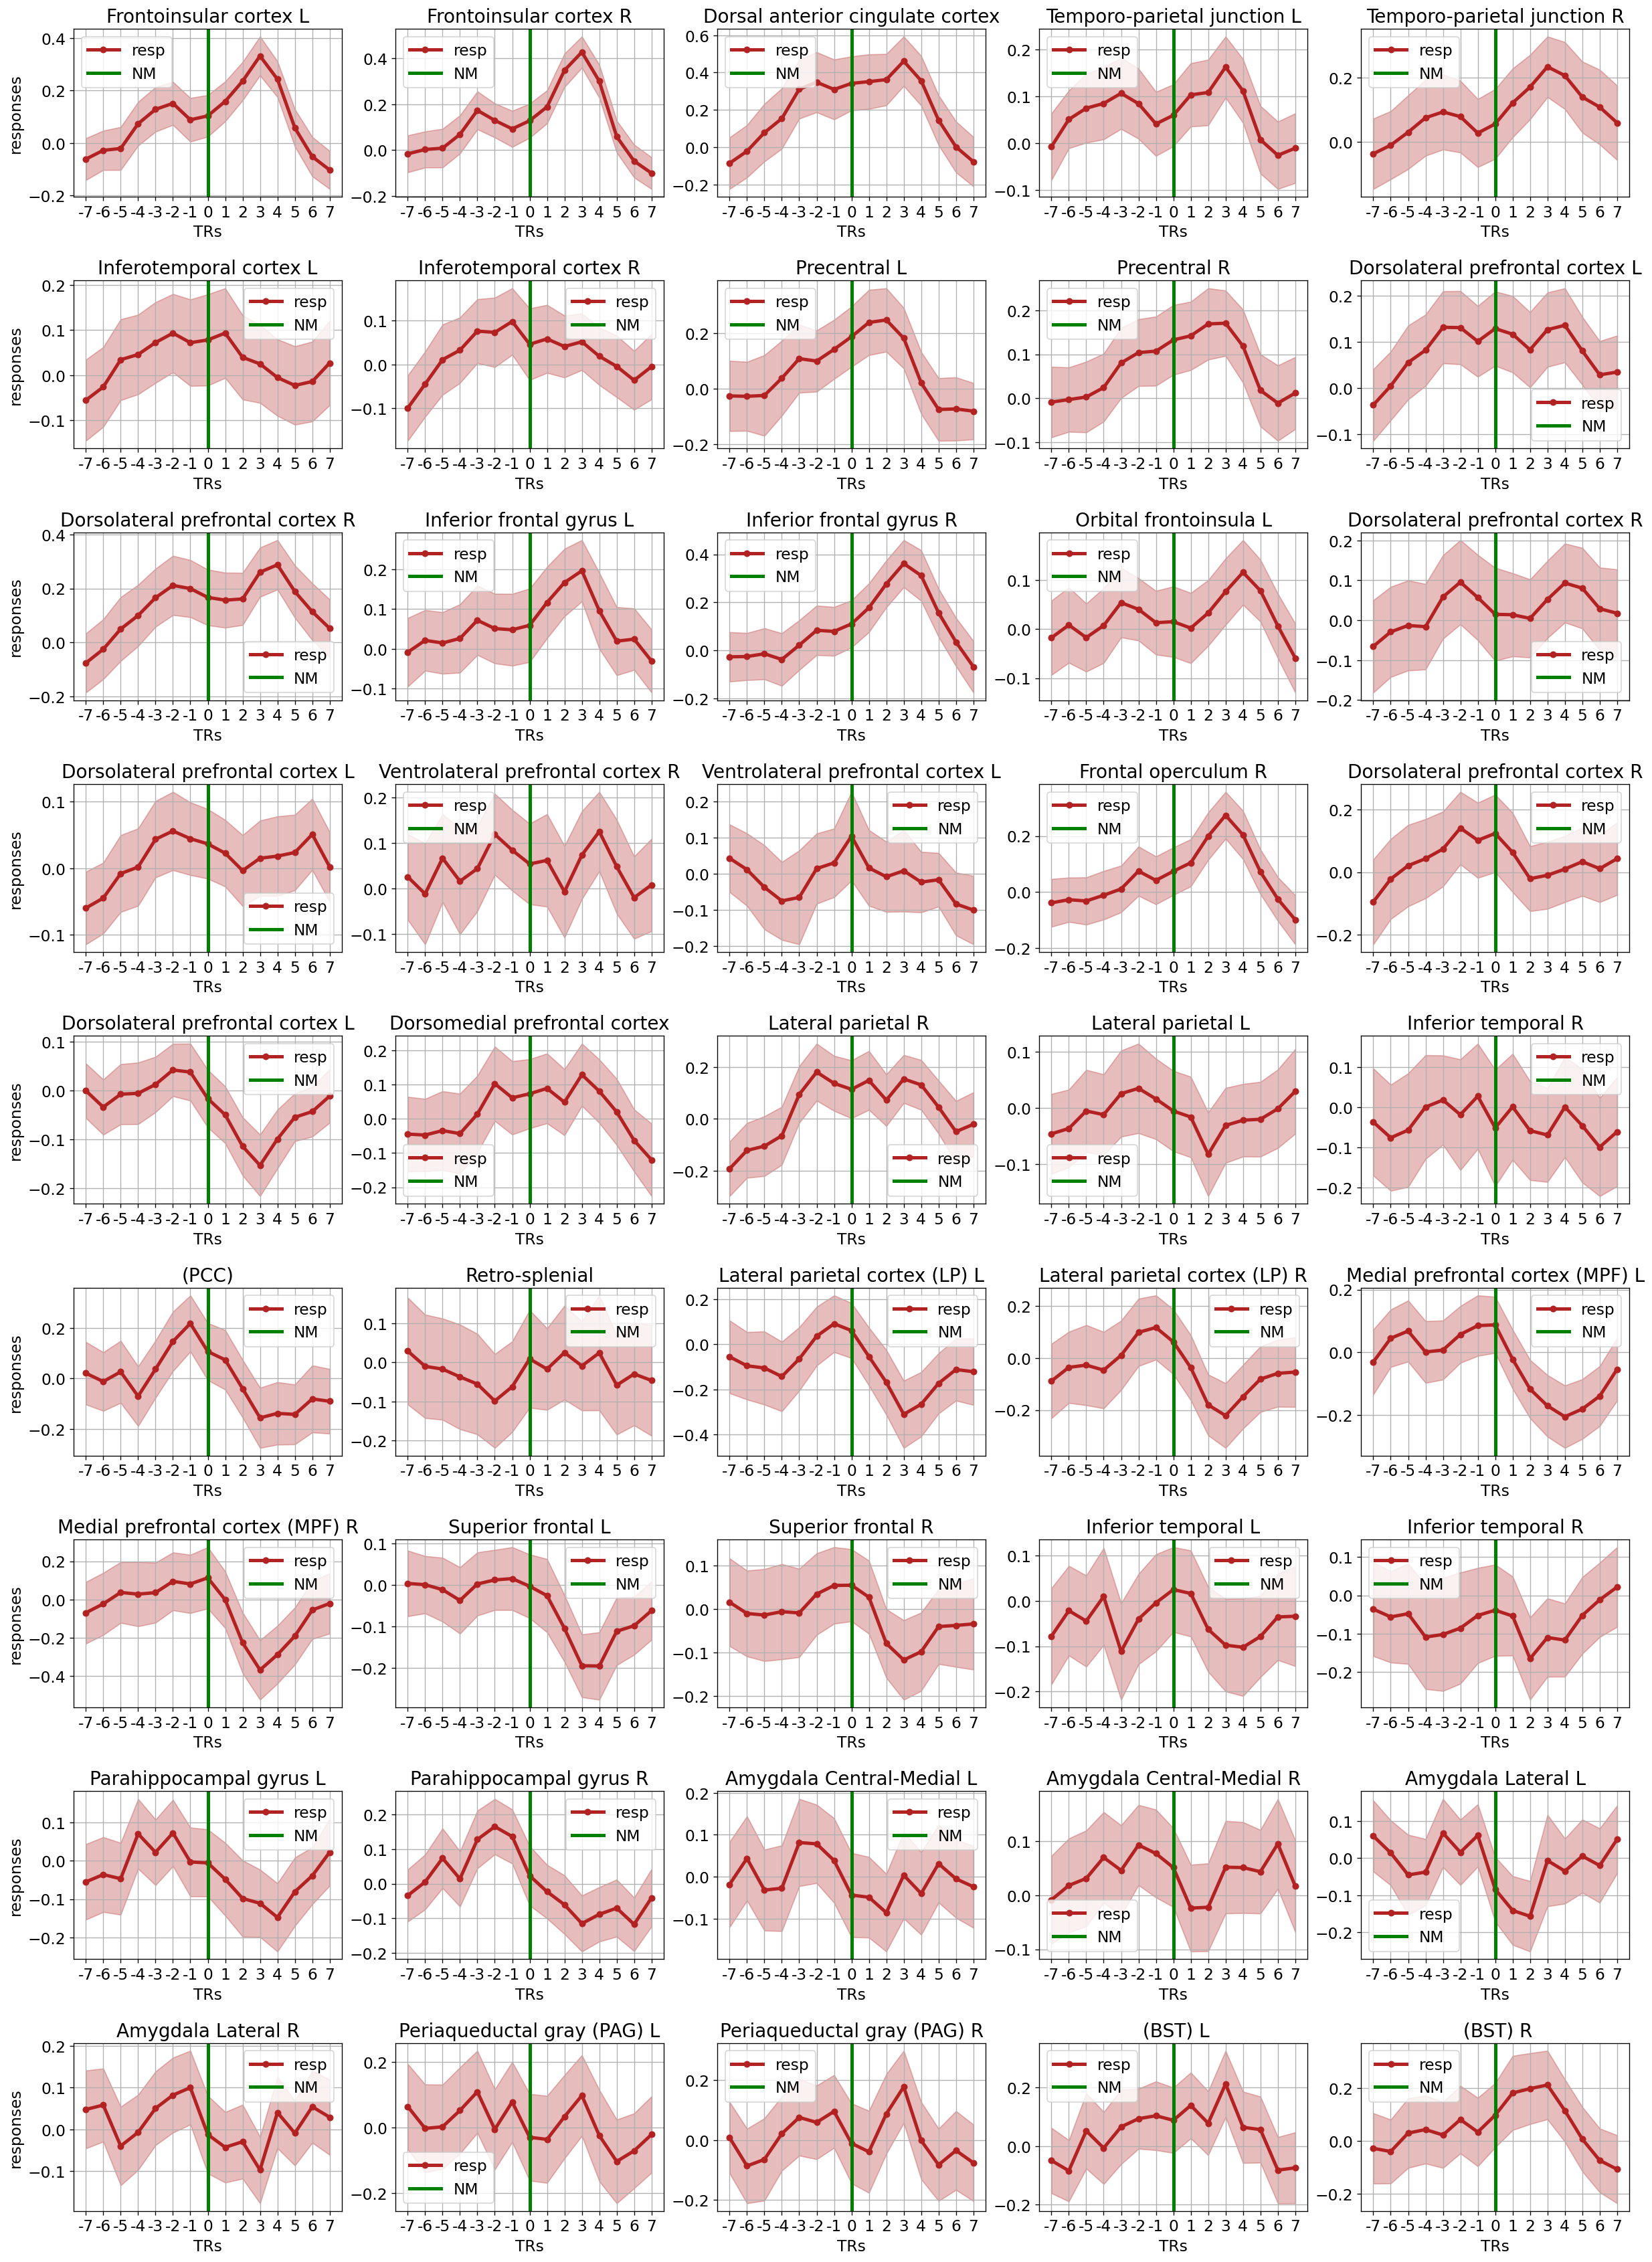

In [4]:
X = dataset_utils.get_emo2_near_miss_responses(args, motion_df)

args.plot_colors = {'NEAR_MISS': 'firebrick'}
dataset_utils.plot_emo2_near_miss_responses(args, X)

In [5]:
X = np.stack(X, axis=-1)

In [6]:
# ROI responses at each TR
# args.plot_colors = {
#     0:'firebrick', 1:'olivedrab', 2:'darkviolet', 
#     3:'steelblue', 4:'goldenrod', 5:'peru', 
#     6:'forestgreen', 7:'mediumpurple', 8:'darkcyan',
#     9:'salmon', 10:'mediumblue', 11:'orange', 12:'darkslategrey',
#     13:'chocolate', 14:'seagreen'
# }
# X_tr = dataset_utils.plot_emo2_near_miss_TRwise_responses(args, X)

In [7]:
# subject-wise responses at each TR
ts = dataset_utils.get_emo2_near_miss_TRwise_responses(args, X)

## ISC

100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


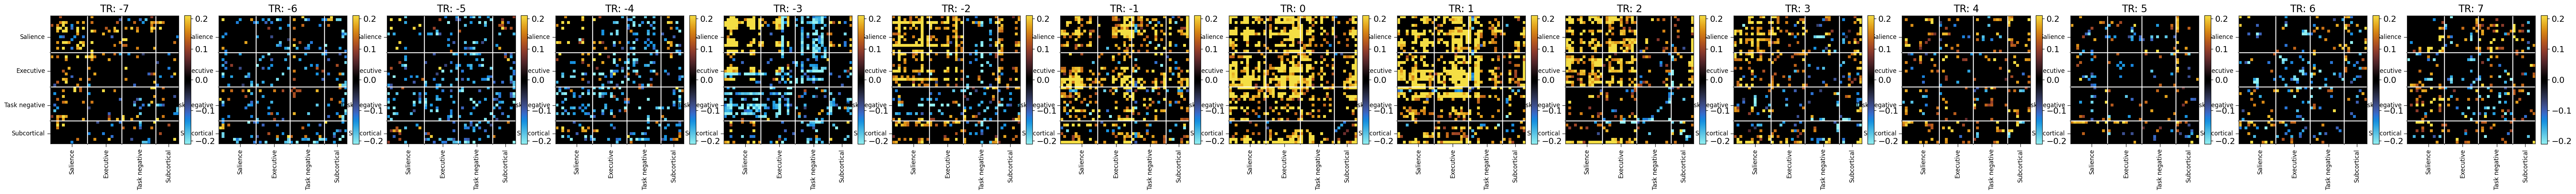

In [8]:
# ISC matrices at each TR
args.CORR_NAMES = ['isfcs', 'iscs']
args.pairwise=False
args.vectorize_isfcs = True
args.n_bootstraps = 1000
args.positive_only = False
(
    corrs, 
    bootstraps, 
    rois
) = isc_utils.get_isfcs(
    args, 
    ts
)
(
    observed_isfcs, observed_p_vals, 
    significant_rois, conf_intervals
) = isc_utils.get_squareform_matrices(
    args, 
    bootstraps, 
    rois,
    threshold_mats=True
)
isc_utils.plot_emo2_near_miss_isfcs(
    args, 
    observed_isfcs, 
    significant_rois
)

In [9]:
# # difference ISCs
# stats_results = isc_utils.get_comparison_stats(
#     args, 
#     corrs,
#     paradigm='emo2_near_miss',
#     how_pairs='consecutive',
# )
# (
#     diff_isfcs, 
#     diff_pvals
# ) = isc_utils.get_diff_isfcs(
#     args, 
#     stats_results, 
#     significant_rois, 
#     threshold_mats=True
# )
# isc_utils.plot_emo2_near_miss_isfc_comparisons(
#     args, 
#     corrs, 
#     diff_isfcs, 
#     paradigm='emo2_near_miss'
# )

In [10]:
# bootstrap ISCs
(
    bootstrap_isfcs, 
    all_isfcs
) = isc_utils.get_bootstrap_distribution_isfcs(
    args, 
    observed_isfcs, 
    bootstraps,
)

In [11]:
# separate positive and negative weights
(
    all_isfcs_pos, all_isfcs_neg,
    all_sq_isfcs_pos, all_sq_isfcs_neg
) = isc_utils.separate_pos_neg_weights(
    args, 
    all_isfcs, 
    significant_rois
)

## Analysis

### network-weight plots

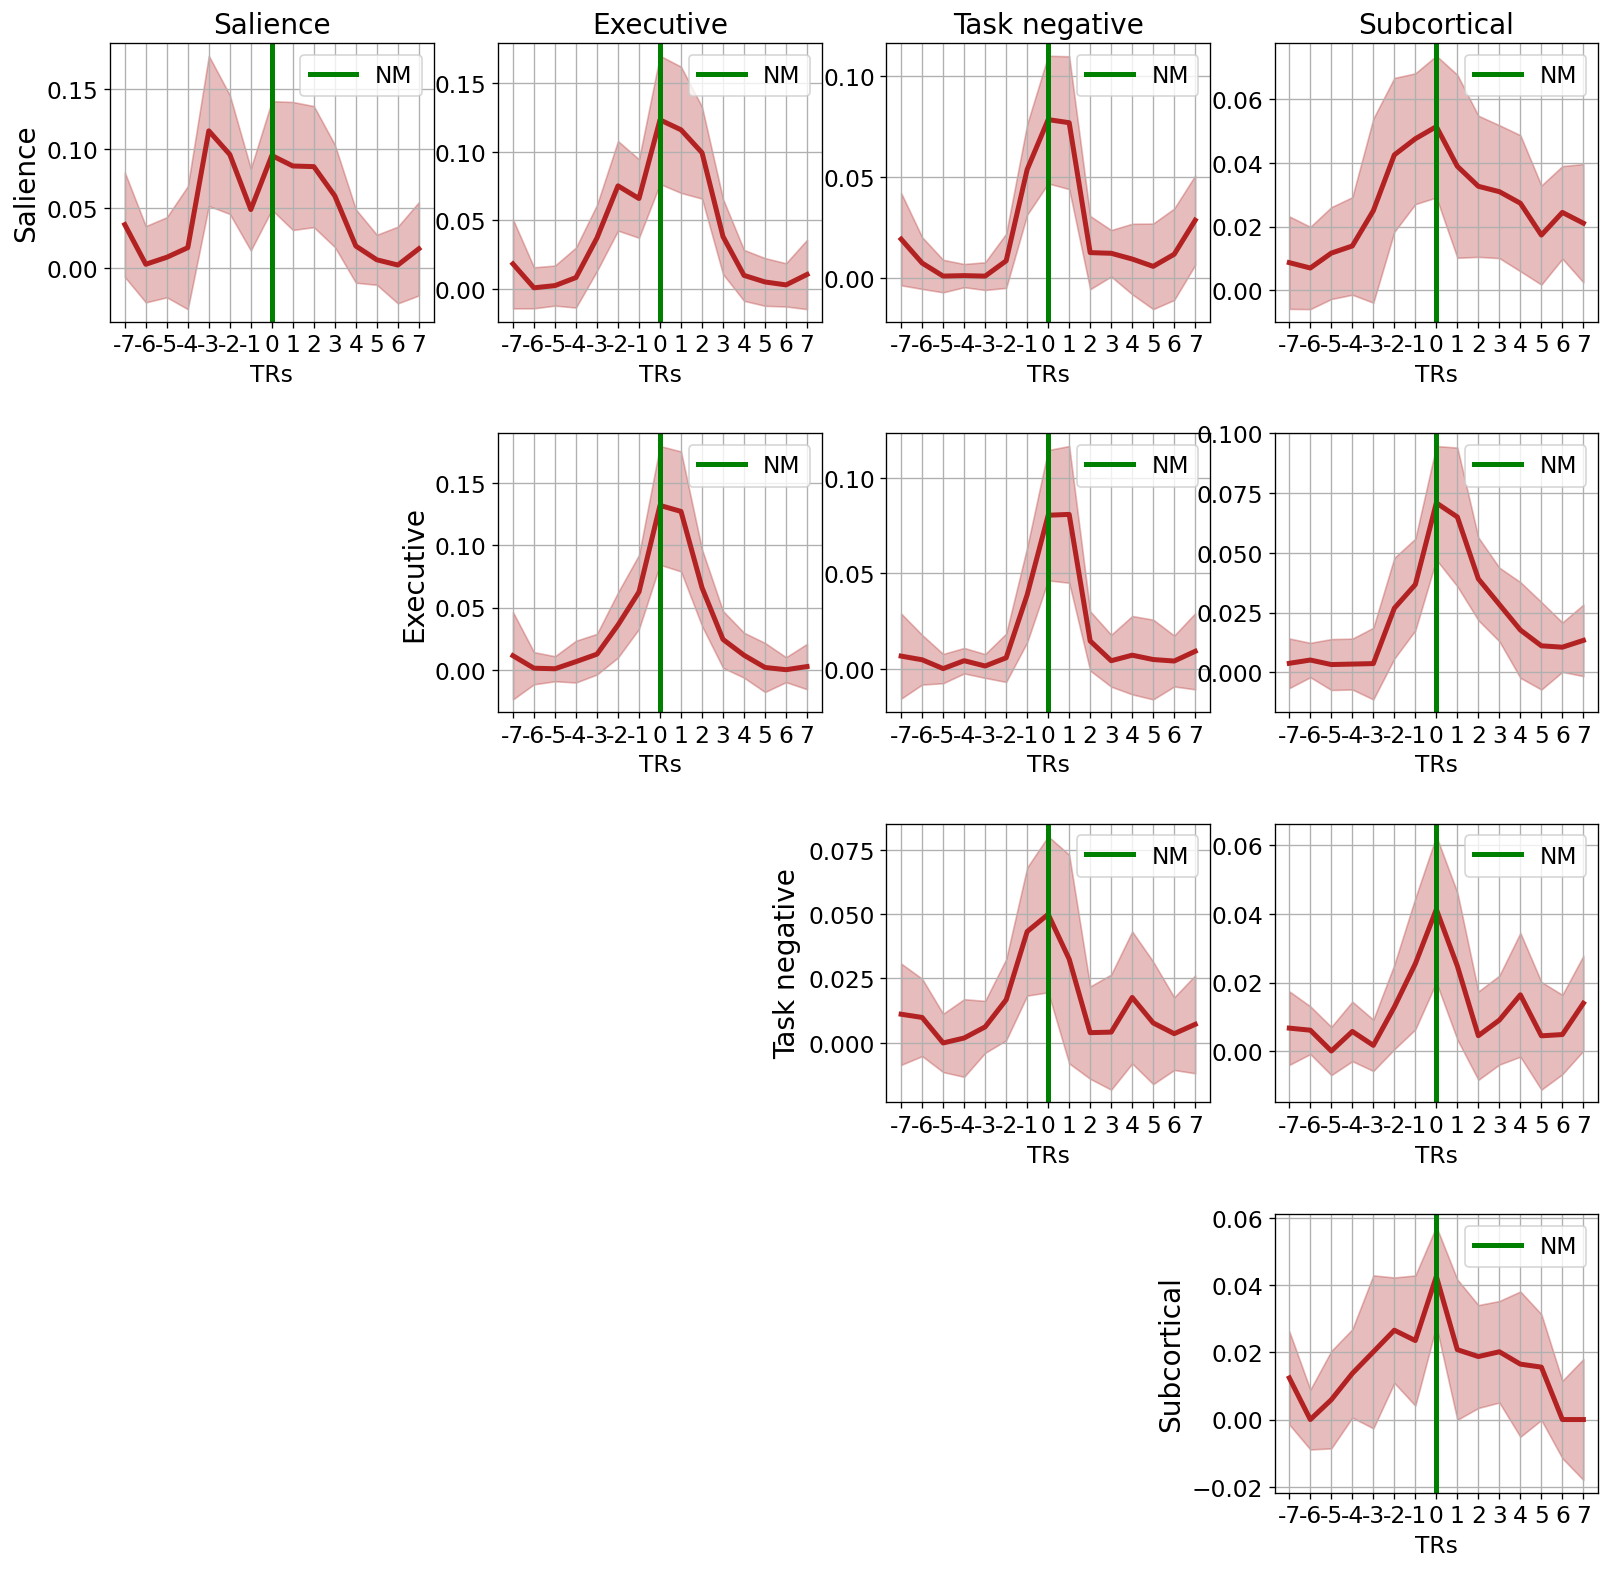

In [12]:
# within- and between-network positive weights
nw_weights_pos = isc_utils.get_nw_weights(
    args, 
    all_sq_isfcs_pos
)

args.plot_colors = {'NEAR_MISS': 'firebrick'}
isc_utils.plot_emo2_near_miss_nw_weights(args, nw_weights_pos)

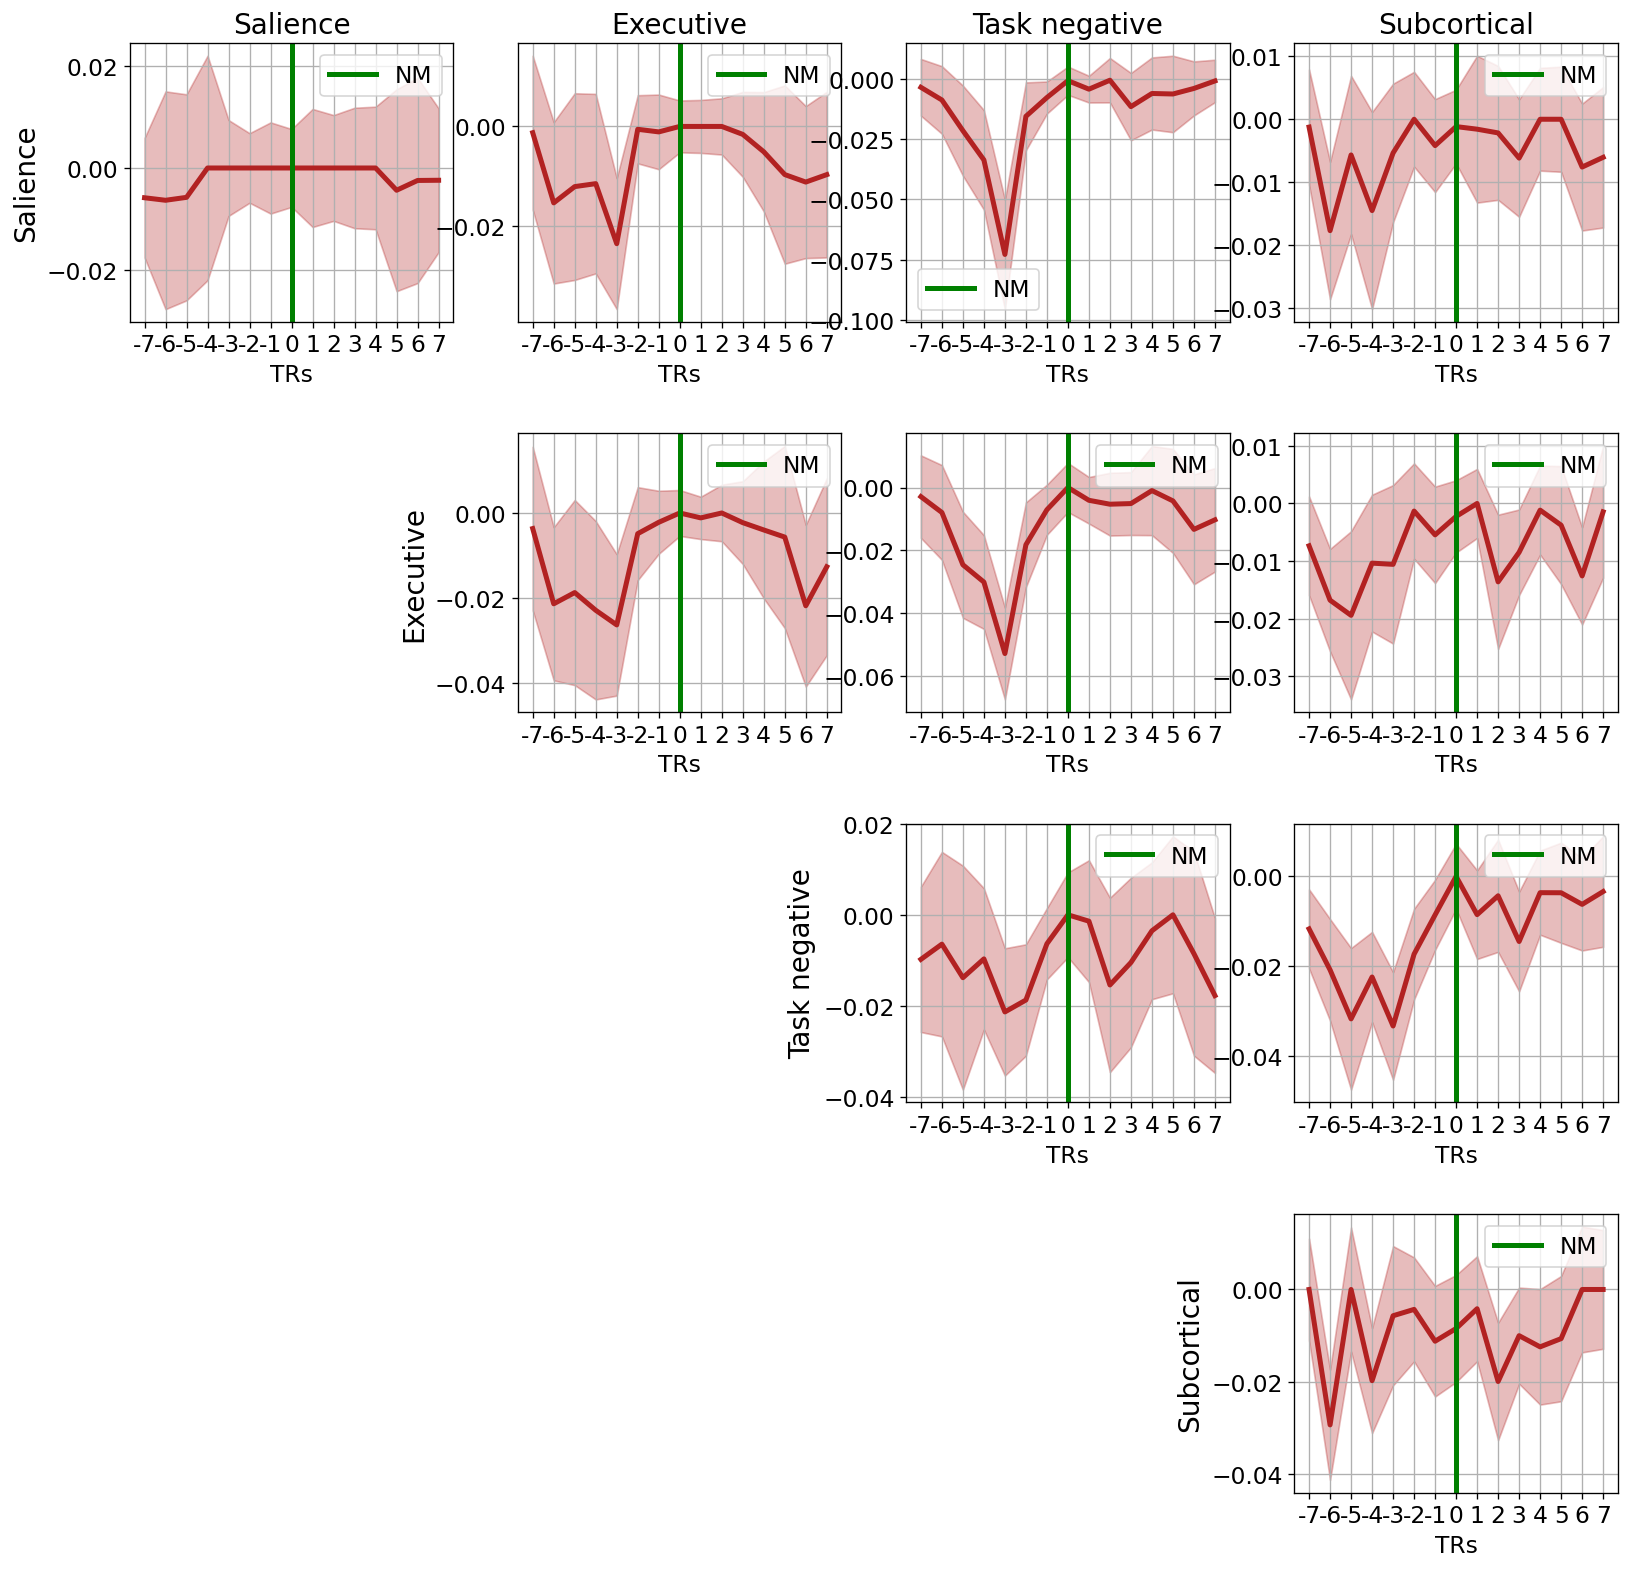

In [13]:
# within- and between-network negative weights
nw_weights_neg = isc_utils.get_nw_weights(
    args, 
    all_sq_isfcs_neg
)

args.plot_colors = {'NEAR_MISS': 'firebrick'}
isc_utils.plot_emo2_near_miss_nw_weights(args, -1 * nw_weights_neg,)

### basic network measures
<!-- 1. **integration**: efficiency -->
<!-- 2. **segregation**: modularity
3. **centrality**: betweenness -->

In [14]:
def compute_network_measures(args, all_sq_isfcs):
    nw_measures = {}

    # efficiency
    nw_measures['efficiency'] = np.array([
        bct.distance.efficiency_wei(all_sq_isfcs[block][:, :, 0], local=False)
        for block in all_sq_isfcs.keys()
    ])

    # betweenness centrality
    nw_btwness = np.zeros(shape=(len(args.SEGMENT_TRS), len(args.nw_roi_idxs.keys())))
    for idx_block, block in enumerate(all_sq_isfcs.keys()):
        
        b = bct.centrality.betweenness_wei(all_sq_isfcs[block][:, :, 0])
        
        for idx_nw, nw in enumerate(args.nw_roi_idxs.keys()):
            
            nw_btwness[idx_block, idx_nw] = np.mean([b[args.nw_roi_idxs[nw]]])

    nw_measures['betweenness'] = nw_btwness

    return nw_measures

def plot_global_efficiency(args, nw_measures):
    fig, axs = plt.subplots(
        nrows=1, 
        ncols=1,
        figsize=(5, 4),
        dpi=120
    )
    ax = axs
    ax.plot(
        args.SEGMENT_TRS,
        nw_measures['efficiency'],
        linewidth=3,
        marker='.',
        markersize=10,
        color=args.plot_colors['efficiency']
    )
    ax.axvline(x=0, linewidth=3, color='green', label='NM')
    ax.set_title(f"{args.title}")
    ax.set_xlabel(f"TRs")
    ax.set_ylabel(f"efficiency")
    ax.legend()
    ax.set_xticks(args.SEGMENT_TRS)
    ax.set_xticklabels(args.SEGMENT_TRS)
    ax.grid(True)

def plot_betweenness(args, nw_measures):
    nrows, ncols = 1, 1
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=(10*ncols, 4*nrows),
        dpi=120
    )

    ax = axs

    for idx_nw, nw in enumerate(args.nw_roi_idxs.keys()):
        ax.plot(
            args.SEGMENT_TRS,
            nw_measures['betweenness'][:, idx_nw],
            linewidth=3,
            color=args.plot_colors[idx_nw],
            marker='.',
            markersize=10,
            label=nw
        )

    ax.axvline(x=0, linewidth=3, color='green', label='NM')
    ax.set_title(f"{args.title}")
    ax.set_xlabel(f"TRs")
    ax.set_ylabel(f"betweenness")
    ax.legend()
    ax.set_xticks(args.SEGMENT_TRS)
    ax.set_xticklabels(args.SEGMENT_TRS)
    ax.grid(True)

nw_measures_pos = compute_network_measures(args, all_sq_isfcs_pos.copy())
nw_measures_neg = compute_network_measures(args, all_sq_isfcs_neg.copy())

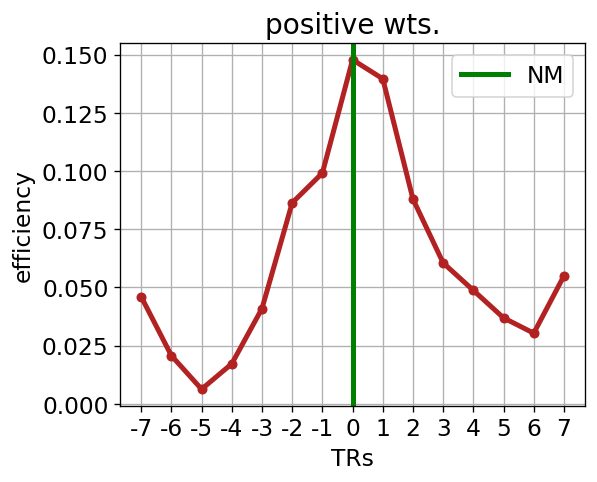

In [15]:
args.plot_colors = {'efficiency':'firebrick'}
args.title = f"positive wts."
plot_global_efficiency(args, nw_measures_pos)

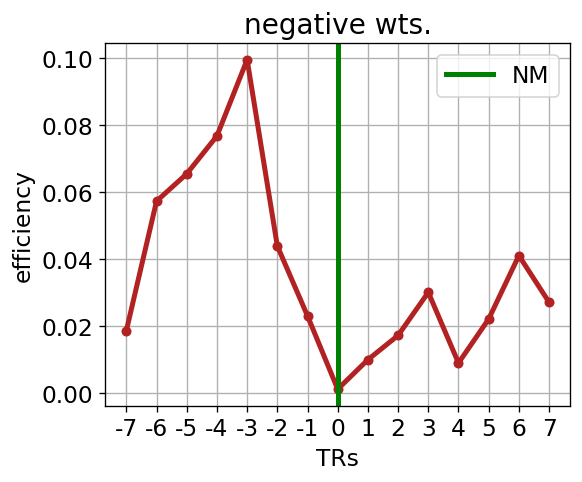

In [16]:
args.plot_colors = {'efficiency':'firebrick'}
args.title = f"negative wts."
plot_global_efficiency(args, nw_measures_neg)

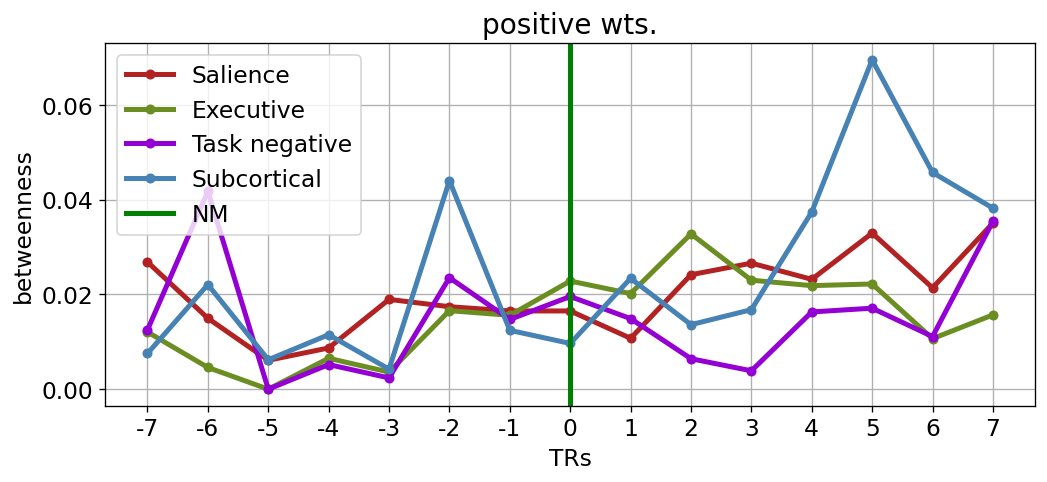

In [17]:
args.plot_colors = {
    0:'firebrick', 1:'olivedrab', 2:'darkviolet', 
    3:'steelblue'
}
args.title = f"positive wts."
plot_betweenness(args, nw_measures_pos)

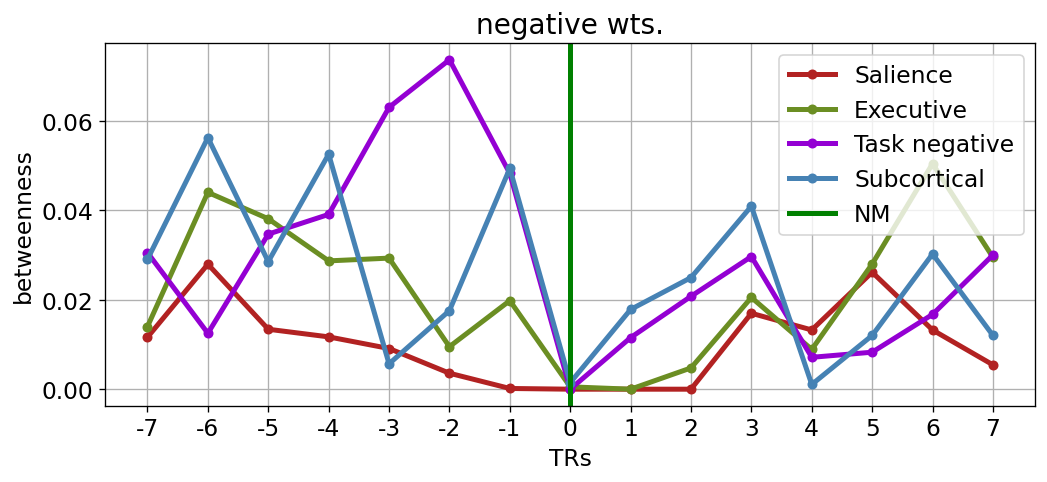

In [18]:
args.plot_colors = {
    0:'firebrick', 1:'olivedrab', 2:'darkviolet', 
    3:'steelblue'
}
args.title = f"negative wts."
plot_betweenness(args, nw_measures_neg)

1. confidence intervals around each plot